## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [348]:
#Parameter defining
size=(1280 , 720)
mask_color = 255
left_bottom=(90,size[1])
left_top=(600,450)
right_top=(750,450)
right_bottom=(size[0]-20 , size[1])
vertices =np.array([ [ left_bottom , left_top , right_top , right_bottom] ],dtype=np.int32)
#design the perspective transform module
#define dst point inside a image
dst_lb=(0,720)
dts_lt=(0,0)
dts_rt=(1280,0)
dts_rb=(1280,720)
dst_pts =np.float32([[ dst_lb , dts_lt , dts_rt , dts_rb]])
src_pts = np.float32(vertices)

In [350]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [351]:
def region_mask(image,Cmat , Dist ):
    undistort_img = cv2.undistort(image , Cmat , Dist ,None , Cmat)
    #gray sclae image
    img_gray = cv2.cvtColor(undistort_img , cv2.COLOR_BGR2GRAY)
    #HLS colour space
    img_HLS = cv2.cvtColor(undistort_img , cv2.COLOR_BGR2HLS)
    # S space image
    img_S = img_HLS[:,:,2]
    #S space low threshold
    low_threshold = 100
    threshold = img_S <=low_threshold
    thresh_S = np.copy(img_S)
    thresh_S[threshold]=0
    #apply Canny edge detector
    Canny_edge = cv2.Canny(thresh_S , 100 , 200)
    #create a image mask
    mask = np.zeros_like(img_gray)
    cv2.fillPoly(mask , vertices ,mask_color)
    mask_edges = cv2.bitwise_and(mask , thresh_S)
    mask_original = cv2.bitwise_and(mask_edges ,img_gray)
    output = np.copy(mask_original)
    cv2.line(mask_original , (left_bottom[0],left_bottom[1]), (left_top[0] , left_top[1]) , color=[255,0,0] , thickness =1 )
    cv2.line(mask_original , (left_top[0],left_top[1]), (right_top[0] , right_top[1]) , color=[255,0,0] , thickness =1 )
    cv2.line(mask_original , (right_top[0],right_top[1]), (right_bottom[0] , right_bottom[1]) , color=[255,0,0] , thickness =1 )
    cv2.line(mask_original , (right_bottom[0],right_bottom[1]), (left_bottom[0] , left_bottom[1]) , color=[255,0,0] , thickness =1 )

    return mask_original , output

In [352]:
def wrapping(image):
    dst_lb=(0,720)
    dts_lt=(0,0)
    dts_rt=(1280,0)
    dts_rb=(1280,720)
    dst_pts =np.float32([[ dst_lb , dts_lt , dts_rt , dts_rb]])
    src_pts = np.float32(vertices)  
    M_transform = cv2.getPerspectiveTransform(src_pts, dst_pts)
    M_inverse = cv2.getPerspectiveTransform(dst_pts , src_pts)
    result_wraped = cv2.warpPerspective(image, M_transform ,(image.shape[1], image.shape[0]))

    return result_wraped , M_inverse

In [353]:
def find_lanelines(wrapped_image):
    #output image
    out_img = np.dstack((wrapped_image,wrapped_image,wrapped_image))
    #define the  histogram of the image at the bottom of the image
    histogram = np.sum(wrapped_image[wrapped_image.shape[0]//2:,:],axis=0)
    #define the midpoint of the histogram
    mid_point = np.int(histogram.shape[0]//2)
    left_base = np.argmax(histogram[:mid_point],axis=0)
    right_base = np.argmax(histogram[mid_point:],axis=0)+mid_point
    #nuber of windows
    n_windows= 9
    margin =100
    min_pts=50
    window_height =np.int(wrapped_image.shape[0]//n_windows)
    right_lane_current = right_base
    left_lane_current = left_base
    nonzeros=wrapped_image.nonzero()
    nonzeroy=np.array(nonzeros[0])
    nonzerox = np.array(nonzeros[1])
    left_lane_pts=[]
    right_lane_pts=[]
    for i in range (n_windows):
        #start from the bottom of the image
        win_y_low = wrapped_image.shape[0] - (i+1)*window_height
        win_y_high = wrapped_image.shape[0] - (i)*window_height
        win_left_x_low =np.clip(left_lane_current - margin  , 0 , wrapped_image.shape[1])
        win_left_x_high=np.clip(left_lane_current + margin , 0 , wrapped_image.shape[1])
        win_right_x_low = np.clip(right_lane_current - margin , 0 , wrapped_image.shape[1])
        win_right_x_high =np.clip(right_lane_current + margin , 0 , wrapped_image.shape[1])
        #draw a window on image
        cv2.rectangle(out_img, (win_left_x_low,win_y_low),(win_left_x_high,win_y_high),(0,255,0),2)
        cv2.rectangle(out_img , (win_right_x_low,win_y_low) , (win_right_x_high,win_y_high) , (0,255,0),2)

        #need to obtain the indices
        left_idx =((win_y_low <=nonzeroy) & (nonzeroy < win_y_high) & (win_left_x_low <=nonzerox) & (win_left_x_high > nonzerox)).nonzero()[0]
        right_idx =((win_y_low<=nonzeroy) & (nonzeroy < win_y_high) & (win_right_x_low <=nonzerox ) & (win_right_x_high > nonzerox)).nonzero()[0]
        left_lane_pts.append(left_idx)
        right_lane_pts.append(right_idx)
        if(len(left_idx) > min_pts):
            left_lane_current = np.int(np.mean(nonzerox[left_idx]))
        if(len(right_idx)>min_pts):
            right_lane_current = np.int(np.mean(nonzerox[right_idx]))

    try:
        left_lane_pts=np.concatenate(left_lane_pts)
        right_lane_pts = np.concatenate(right_lane_pts)

    except ValueError:
        pass
    #obtain all the x and y corrdinates
    left_x = nonzerox[left_lane_pts]
    left_y = nonzeroy[left_lane_pts]
    right_x = nonzerox[right_lane_pts]
    right_y = nonzeroy[right_lane_pts]

    return left_x,left_y , right_x , right_y , out_img

In [354]:
def fit_polynomial(wrapped_image):
    #call the sliding windows function
    left_x , left_y , right_x , right_y , out_img = find_lanelines(wrapped_image)
    #fit second order polynomials for the points
    left_poly = np.polyfit(left_y , left_x , 2)
    right_poly = np.polyfit(right_y , right_x , 2)
    
    ploty = np.linspace(0,wrapped_image.shape[0]-1 , wrapped_image.shape[0])
    try :
        leftpoly_x = left_poly[0]*ploty**2 + left_poly[1]*ploty + left_poly[2]
        rightpoly_x = right_poly[0]*ploty**2 + right_poly[1]*ploty + right_poly[2]
    except TypeError:
        print("Polynomial is not fitting")
        pass
    #color the lines
    out_img[left_y , left_x]=[255,0,0]
    out_img[right_y ,right_x]=[0,255,0]
    #plt.plot(leftpoly_x , ploty , color='yellow')
    #plt.plot(rightpoly_x,ploty , color='yellow')

    return out_img , left_poly , right_poly

In [355]:
def fit_poly(left_x,left_y,right_x,right_y, img):
    left_poly = np.polyfit(left_y , left_x , 2)
    right_poly = np.polyfit(right_y , right_x , 2)
    #define the y axis linespace
    polty = np.linspace(0,img.shape[0]-1 , img.shape[0])
    try:
        left_x = left_poly[0]*(polty**2)+left_poly[1]*polty + left_poly[2]
        right_x = right_poly[0]*(polty**2) + right_poly[1]*polty + right_poly[2]

    except TypeError:
        print(" Fail to fit to the polynomail")
        pass
    return left_poly , right_poly , left_x , right_x , polty

In [356]:
#define the next frame points using the previous image polynomial
def search_around_poly(wrapped_image,left_poly,right_poly):
    margin =100
    #obtain the indices of nonzero values in image
    nonzeros=wrapped_image.nonzero()
    nonzerox=nonzeros[1]
    nonzeroy = nonzeros[0]
    out_img=np.dstack((wrapped_image, wrapped_image , wrapped_image))
    window_img=np.zeros_like(out_img)
    #find the nonzerox values around the polynomial
    left_lane_idx=(nonzerox >= (left_poly[0]*(nonzeroy**2) + left_poly[1]*nonzeroy + left_poly[2] - margin  )) & (nonzerox < ( left_poly[0]*(nonzeroy**2) + left_poly[1]*nonzeroy +                          left_poly[2] +margin ))

    right_lane_idx=(nonzerox >= (right_poly[0]*(nonzeroy**2) + right_poly[1]*nonzeroy + right_poly[2] -margin )) & (nonzerox < (right_poly[0]*(nonzeroy**2) + right_poly[1]*nonzeroy +                                right_poly[2] +margin)) 


    left_x = nonzerox[left_lane_idx]
 
    left_y = nonzeroy[left_lane_idx]
   
    right_x = nonzerox[right_lane_idx]
    
    right_y=nonzeroy[right_lane_idx]
    
    #fit a polynomial for the points
    left_poly , right_poly , leftpoly_x , rightpoly_x , ploty =fit_poly(left_x , left_y , right_x , right_y , wrapped_image)

    out_img[left_y , left_x] = [255 , 0 , 0]
    out_img[right_y , right_x] = [0 , 255 , 0 ]

    #define the left and right margin region
    left_window1=np.array([np.transpose(np.vstack([leftpoly_x - margin ,ploty ]))])
    left_window2=np.array([np.flipud(np.transpose(np.vstack([leftpoly_x+margin , ploty])))])
    left_window= np.hstack((left_window1, left_window2))
    right_window1=np.array([np.transpose(np.vstack([rightpoly_x-margin , ploty]))])
    right_window2=np.array([np.flipud(np.transpose(np.vstack([rightpoly_x+margin , ploty])))])
    right_window=np.hstack((right_window1,right_window2))

    #draw the window in window image
    cv2.fillPoly(window_img, np.int_([left_window]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_window]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    #plt.plot(leftpoly_x,ploty,color='yellow')
    #plt.plot(rightpoly_x,ploty,color='yellow')

    return result,window_img

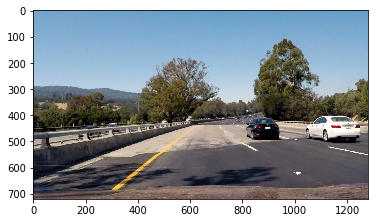

In [357]:
#obtain the test images
%matplotlib inline
test_images = glob.glob("../test_images/test*.jpg")
#test_img = cv2.imread(test_images[3])
test_img = mpimg.imread(test_images[0])
plt.imshow(test_img)


# Pipeline steps

* read every image from the video frame 
* if the image frame is the initial frame then use the search from the scrach
* if the image is not the initial frame then continoue with the previous polynomial defined prevoius frame 
* check for the defined left and right paths for curavtuer , slope whether matching the real scenario
* if so then map the output into the image frame
* if not then reinitialize the search



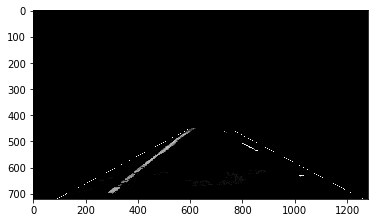

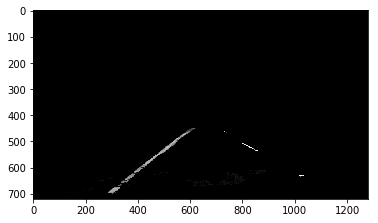

In [358]:
#calibrate camera
ret , Cmat , Dist , rvec , tvec = cv2.calibrateCamera(objpoints , imgpoints , size, None ,None)
result_mask , output = region_mask(test_img , Cmat , Dist)
plt.imshow(result,cmap='gray')
plt.show()
plt.imshow(output , cmap='gray')
plt.show()

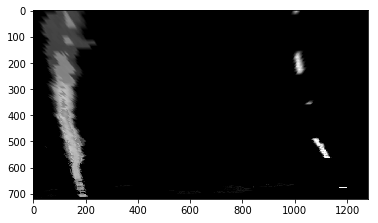

In [359]:
result_wraped , M_unwrapped = wrapping(output)
plt.imshow(result_wraped,cmap='gray')

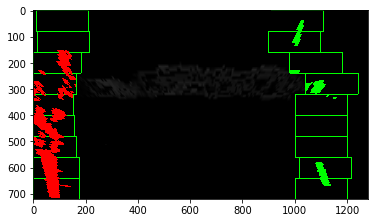

In [360]:
lane_image , left_poly , right_poly=fit_polynomial(wrapped_image)
plt.imshow(lane_image)
plt.show()

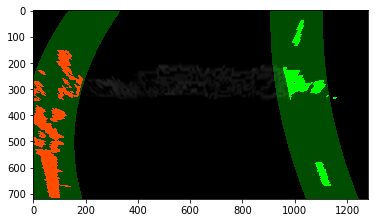

In [361]:
result_img , window_img= search_around_poly(wrapped_image,left_poly,right_poly)
plt.imshow(result_img)
plt.show()

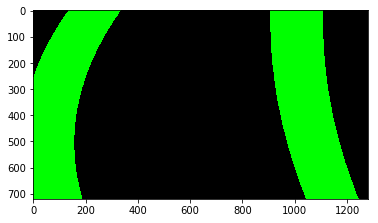

In [362]:
plt.imshow(window_img)
plt.show()

## And so on and so forth...

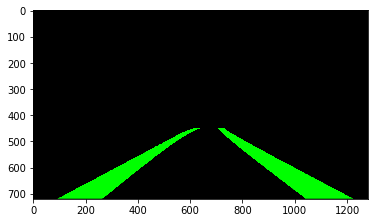

In [365]:
#unwrapped in to the original image
unwrapped_image=cv2.warpPerspective(window_img,M_unwrapped,(result_img.shape[1],result_img.shape[0]))
plt.imshow(unwrapped_image)
plt.show()

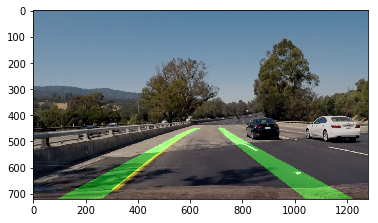

In [364]:
output_img =cv2.addWeighted(test_img,0.8 , unwrapped_image , 0.4 ,0)
plt.imshow(output_img)
plt.show()

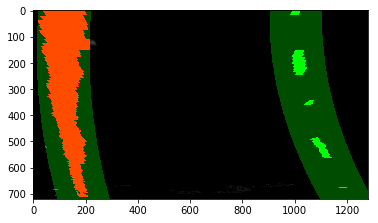

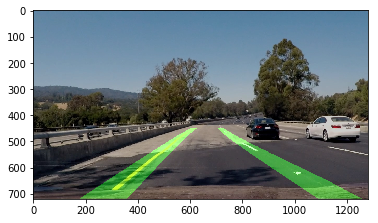

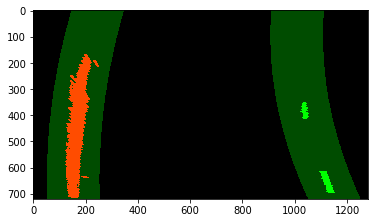

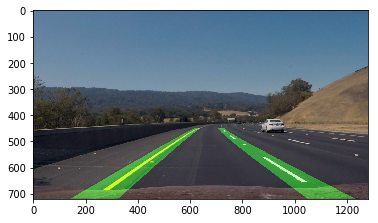

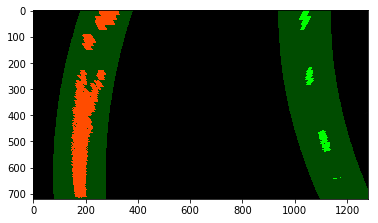

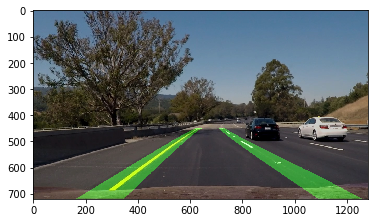

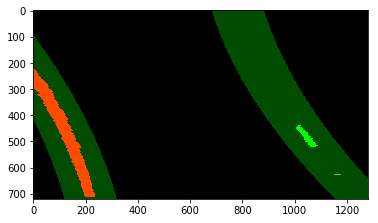

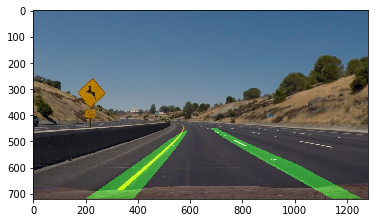

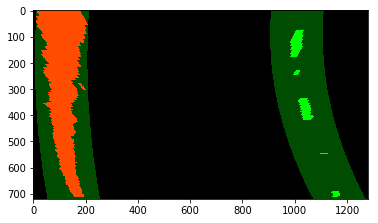

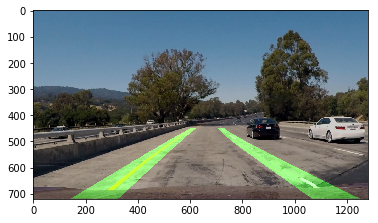

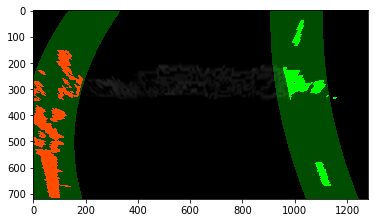

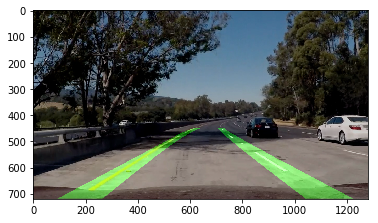

In [367]:
for img_file in test_images:
    test_img = mpimg.imread(img_file)
    result_mask , output = region_mask(test_img , Cmat , Dist)
    dst_pts =np.float32([[ dst_lb , dts_lt , dts_rt , dts_rb]])
    src_pts = np.float32(vertices)  
    M_transform = cv2.getPerspectiveTransform(src_pts, dst_pts)
    M_inverse = cv2.getPerspectiveTransform(dst_pts , src_pts)
    result_wraped = cv2.warpPerspective(output, M_transform ,(output.shape[1], output.shape[0]))
    wrapped_image , M_unwrapped = wrapping(output)
    lane_image , left_poly , right_poly=fit_polynomial(result_wraped)
    result_img , window_img= search_around_poly(wrapped_image,left_poly,right_poly)
    plt.imshow(result_img)
    plt.show()
    unwrapped_image=cv2.warpPerspective(window_img,M_unwrapped,(result_img.shape[1],result_img.shape[0]))
    output_img =cv2.addWeighted(test_img,0.8 , unwrapped_image , 0.4 ,0)
    plt.imshow(output_img)
    plt.show()